In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow import keras

In [ ]:
images = []
mask = glob.glob("/content/drive/MyDrive/Dataset_BUSI_with_GT/*/*_mask.png")
for i in mask:
    images.append(i.replace('_mask',''))

In [ ]:
print(images[:5])
print(mask[:5])

['/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (98).png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (87).png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (90).png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (83).png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (82).png']
-------------------
['/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (98)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (87)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (90)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (83)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (82)_mask.png']


In [ ]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

,images,masks
0,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...
1,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...
2,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...
3,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...
4,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...
5,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...
6,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...
7,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...
8,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...


In [ ]:
data.shape

(780, 2)

In [ ]:
data_train,data_test=train_test_split(data,test_size=0.1)

data_train,data_val=train_test_split(data_train,test_size=0.1)

In [ ]:
datagen = ImageDataGenerator(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            rescale=1./255)

In [ ]:
image_train=datagen.flow_from_dataframe(data_train,
                                    target_size=(512,512),
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images",
                                    batch_size=8,
                                    class_mode=None

)
mask_train=datagen.flow_from_dataframe(data_train,
                                    target_size=(512,512),
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks",
                                    batch_size=8,
                                    class_mode=None
)

Found 631 validated image filenames.
Found 631 validated image filenames.


In [ ]:
image_validation=datagen.flow_from_dataframe(data_val,
                                    target_size=(512,512),
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images",
                                    batch_size=8,
                                    class_mode=None
)

mask_validation=datagen.flow_from_dataframe(data_val,
                                    target_size=(512,512),
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks",
                                    batch_size=8,
                                    class_mode=None
)

Found 71 validated image filenames.
Found 71 validated image filenames.


In [ ]:
train_gen=zip(image_train,mask_train)
valid_gen=zip(image_validation,mask_validation)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_resnet50_unet(input_shape):

    inputs = Input(input_shape)

    """Pre-trained ResNet50 Model"""
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """Encoder"""
    s1 = resnet50.get_layer("input_1").output #512
    s2 = resnet50.get_layer("conv1_relu").output #256
    s3 = resnet50.get_layer("conv2_block3_out").output #128
    s4 = resnet50.get_layer("conv3_block4_out").output #64

    """Bridge"""
    b1 = resnet50.get_layer("conv4_block6_out").output

    """Decoder"""
    d1 = decoder_block(b1, s4, 512) #64
    d2 = decoder_block(d1, s3, 256) #128
    d3 = decoder_block(d2, s2, 128) #256
    d4 = decoder_block(d3, s1, 64) #512

    """Outputs"""
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)

    return model

In [ ]:
model = build_resnet50_unet((512,512,3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
import tensorflow as tf

def pixel_accuracy(y_true, y_pred):
    # Convert the predicted probabilities to class labels
    y_pred = tf.argmax(y_pred, axis=-1)

    # Flatten the tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # Cast y_true to the same data type as y_pred
    y_true = tf.cast(y_true, y_pred.dtype)

    # Calculate the pixel accuracy
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total_pixels = tf.cast(tf.size(y_true), tf.float32)

    accuracy = correct_pixels / total_pixels
    return accuracy

In [ ]:
import tensorflow as tf
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(K.argmax(y_true), 3)
    y_pred = tf.one_hot(K.argmax(y_pred), 3)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coef


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


from tensorflow.keras.losses import categorical_crossentropy

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [ ]:
import tensorflow.keras as keras
keras.utils.get_custom_objects()['pixel_accuracy'] = pixel_accuracy
keras.utils.get_custom_objects()['dice_coef'] = dice_coef
keras.utils.get_custom_objects()['dice_coef_loss'] = dice_coef_loss
keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss

In [ ]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,'accuracy'])

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    validation_steps=len(data_val) /8,
    steps_per_epoch=len(data_train) /8
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


78/78 [==============================] - 426s 4s/step - loss: 0.3215 - dice_coef: 1.0000 - accuracy: 0.8965 - val_loss: 194.6174 - val_dice_coef: 1.0000 - val_accuracy: 0.0879
Epoch 2/25
78/78 [==============================] - 128s 2s/step - loss: 0.2166 - dice_coef: 1.0000 - accuracy: 0.9297 - val_loss: 2.6462 - val_dice_coef: 1.0000 - val_accuracy: 0.1089
Epoch 3/25
78/78 [==============================] - 127s 2s/step - loss: 0.1940 - dice_coef: 1.0000 - accuracy: 0.9350 - val_loss: 0.3151 - val_dice_coef: 1.0000 - val_accuracy: 0.9331
Epoch 4/25
78/78 [==============================] - 127s 2s/step - loss: 0.1746 - dice_coef: 1.0000 - accuracy: 0.9389 - val_loss: 0.2485 - val_dice_coef: 1.0000 - val_accuracy: 0.9257
Epoch 5/25
78/78 [==============================] - 127s 2s/step - loss: 0.1612 - dice_coef: 1.0000 - accuracy: 0.9432 - val_loss: 0.2275 - val_dice_coef: 1.0000 - val_accuracy: 0.9289
Epoch 6/25
78/78 [==============================] - 127s 2s/step - loss: 0.1609 - di

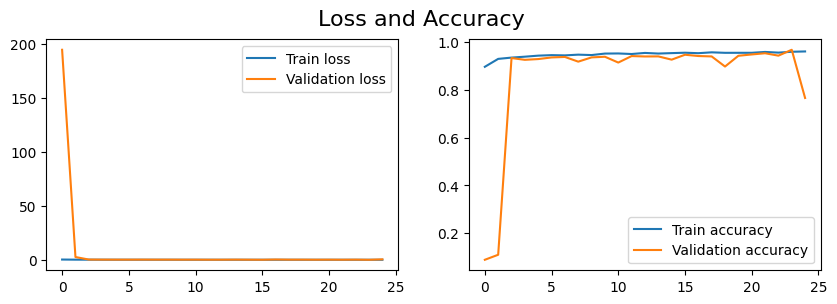

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()